In [9]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla


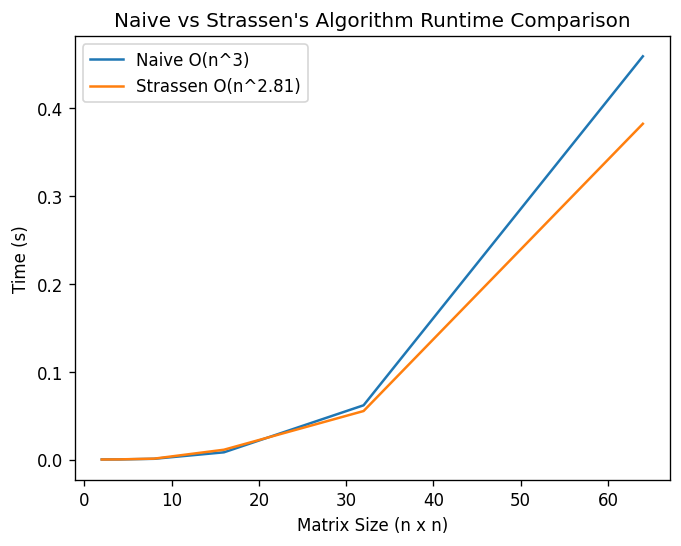

In [4]:
def naive_matrix_multiplication(A, B):
    """ Naïve divide-and-conquer matrix multiplication """
    n = A.shape[0]
    if n == 1:
        return A * B
    
    mid = n // 2
    
    A11, A12, A21, A22 = A[:mid, :mid], A[:mid, mid:], A[mid:, :mid], A[mid:, mid:]
    B11, B12, B21, B22 = B[:mid, :mid], B[:mid, mid:], B[mid:, :mid], B[mid:, mid:]
    
    C11 = naive_matrix_multiplication(A11, B11) + naive_matrix_multiplication(A12, B21)
    C12 = naive_matrix_multiplication(A11, B12) + naive_matrix_multiplication(A12, B22)
    C21 = naive_matrix_multiplication(A21, B11) + naive_matrix_multiplication(A22, B21)
    C22 = naive_matrix_multiplication(A21, B12) + naive_matrix_multiplication(A22, B22)
    
    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))
    return C

def strassen_matrix_multiplication(A, B):
    """ Strassen's algorithm for matrix multiplication """
    n = A.shape[0]
    if n == 1:
        return A * B
    
    mid = n // 2
    
    A11, A12, A21, A22 = A[:mid, :mid], A[:mid, mid:], A[mid:, :mid], A[mid:, mid:]
    B11, B12, B21, B22 = B[:mid, :mid], B[:mid, mid:], B[mid:, :mid], B[mid:, mid:]
    
    M1 = strassen_matrix_multiplication(A11 + A22, B11 + B22)
    M2 = strassen_matrix_multiplication(A21 + A22, B11)
    M3 = strassen_matrix_multiplication(A11, B12 - B22)
    M4 = strassen_matrix_multiplication(A22, B21 - B11)
    M5 = strassen_matrix_multiplication(A11 + A12, B22)
    M6 = strassen_matrix_multiplication(A21 - A11, B11 + B12)
    M7 = strassen_matrix_multiplication(A12 - A22, B21 + B22)
    
    C11 = M1 + M4 - M5 + M7
    C12 = M3 + M5
    C21 = M2 + M4
    C22 = M1 - M2 + M3 + M6
    
    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))
    return C

def empirical_time_analysis():
    """ Compare runtime for naive and Strassen's method """
    sizes = [2**i for i in range(1, 7)]  # Powers of 2
    naive_times, strassen_times = [], []
    
    for size in sizes:
        A, B = np.random.rand(size, size), np.random.rand(size, size)
        
        start = time.time()
        naive_matrix_multiplication(A, B)
        naive_times.append(time.time() - start)
        
        start = time.time()
        strassen_matrix_multiplication(A, B)
        strassen_times.append(time.time() - start)
    plt.figure(dpi=120)
    plt.plot(sizes, naive_times, label='Naive O(n^3)')
    plt.plot(sizes, strassen_times, label='Strassen O(n^2.81)')
    plt.xlabel("Matrix Size (n x n)")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.title("Naive vs Strassen's Algorithm Runtime Comparison")
    plt.show()

empirical_time_analysis()


C:\Users\EricY\AppData\Local\Temp\ipykernel_15480\2215593688.py:45: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = sla.splu(A)  # Sparse LU decomposition


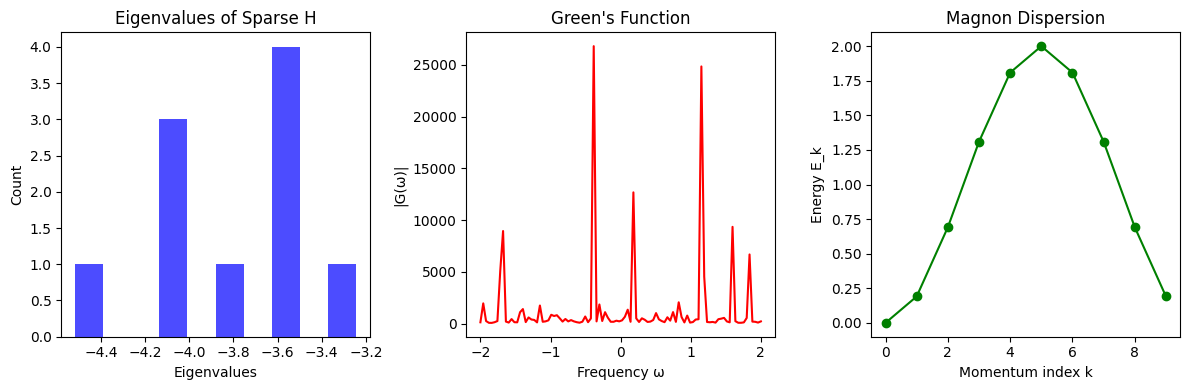

In [10]:


# Define spin operators as sparse matrices
S_plus = sp.csr_matrix([[0, 1], [0, 0]])  # S+
S_minus = sp.csr_matrix([[0, 0], [1, 0]]) # S-
S_z = sp.csr_matrix([[0.5, 0], [0, -0.5]])  # S_z

def heisenberg_xxx_hamiltonian_sparse(N, J=1.0):
    """ Construct the Heisenberg XXX Hamiltonian as a sparse matrix. """
    dim = 2**N  # Hilbert space dimension
    H = sp.lil_matrix((dim, dim))  # Sparse matrix format

    for i in range(N):
        j = (i + 1) % N  # Periodic boundary condition

        for state in range(dim):
            # Convert state to binary representation
            state_bin = format(state, f'0{N}b')
            state_arr = np.array([int(x) for x in state_bin])

            # Sz_i Sz_j term (diagonal)
            if state_arr[i] == state_arr[j]:
                H[state, state] += J * 0.25
            else:
                H[state, state] -= J * 0.25

            # Flip-flop term S+_i S-_j + S-_i S+_j
            if state_arr[i] != state_arr[j]:  # Only applies when spins are opposite
                new_state = state_arr.copy()
                new_state[i], new_state[j] = new_state[j], new_state[i]  # Swap spins
                new_state_int = int("".join(map(str, new_state)), 2)
                H[state, new_state_int] += -0.5 * J

    return H.tocsr()  # Convert to compressed sparse row format for efficiency

# Compute the eigenvalues of the sparse Hamiltonian
def compute_sparse_eigenvalues(H, k=10):
    """ Compute the lowest k eigenvalues of the sparse Hamiltonian. """
    eigvals, _ = sla.eigs(H, k=k, which='SR')  # 'SR' -> smallest real eigenvalues
    return np.real(eigvals)

# Solve Green’s function using sparse LU decomposition
def green_function_sparse(H, omega):
    """ Compute Green's function G = (ωI - H)^(-1) using sparse LU. """
    I = sp.identity(H.shape[0], format="csr")
    A = omega * I - H
    lu = sla.splu(A)  # Sparse LU decomposition
    return lu.solve(I.toarray())  # Solve the system

# Compute Magnon Energy Dispersion
def magnon_energy(N, J=1.0):
    """ Compute energy dispersion E_k = 2J sin²(πk/N) """
    k_vals = np.arange(N)
    E_k = 2 * J * np.sin(np.pi * k_vals / N)**2
    return k_vals, E_k

# Run for N = 10 (large N is infeasible in full space)
N = 10
H_sparse = heisenberg_xxx_hamiltonian_sparse(N)

# Compute 10 smallest eigenvalues
eigvals_sparse = compute_sparse_eigenvalues(H_sparse, k=10)

# Compute Green's function for a sample frequency
omega_vals = np.linspace(-2, 2, 100)
G_norms = [np.linalg.norm(green_function_sparse(H_sparse, omega)) for omega in omega_vals]

# Compute magnon dispersion
k_vals, E_k = magnon_energy(N)

# Plot results
plt.figure(figsize=(12, 4))

# Plot eigenvalues of sparse Hamiltonian
plt.subplot(1, 3, 1)
plt.hist(eigvals_sparse, bins=10, alpha=0.7, color='b')
plt.xlabel("Eigenvalues")
plt.ylabel("Count")
plt.title("Eigenvalues of Sparse H")

# Plot Green’s function norm vs frequency
plt.subplot(1, 3, 2)
plt.plot(omega_vals, G_norms, 'r-')
plt.xlabel("Frequency ω")
plt.ylabel("|G(ω)|")
plt.title("Green's Function")

# Plot magnon energy dispersion
plt.subplot(1, 3, 3)
plt.plot(k_vals, E_k, 'go-')
plt.xlabel("Momentum index k")
plt.ylabel("Energy E_k")
plt.title("Magnon Dispersion")

plt.tight_layout()
plt.show()
